In [1]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

Load VASCA region

In [2]:
region_name = "TDS_ELAI"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32
GNU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,NUV,1.2,True,24,29566.4,54960.17787037037,56821.33210648148,0
GNU2597383053068206080,PS_ELAISN1_MOS11,244.57200462478102,55.1825511621234,GALEX,NUV,1.2,True,25,31369.5,54960.24638888889,56815.50054271557,1
GNU2597453421812383744,PS_ELAISN1_MOS12,242.896209389035,55.0003489374844,GALEX,NUV,1.2,True,21,26349.451,54960.314884259256,56814.569061234084,2
GNU2597523790556561408,PS_ELAISN1_MOS13,241.28881797574297,55.3529870930308,GALEX,NUV,1.2,True,22,27810.902,54960.38337962963,56819.53759259259,3
GNU2597594159300739072,PS_ELAISN1_MOS14,243.95513153083402,54.1978605194106,GALEX,NUV,1.2,True,22,26881.852,54960.451886574076,56810.60611111111,4
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5
GNU2597734896789094400,PS_ELAISN1_MOS16,241.37385712300306,54.4519391954855,GALEX,NUV,1.2,True,21,26780.799,54960.588912037034,56807.7931854022,6


Get TDS & VASCA data and match them positionally

In [3]:
#Select vasca sources, 5 sigma 0.000000573303, 4 sigma 0.00006334, 3 sigma = 0.002699796
sel_vasca = (rg.tt_sources["flux_cpval"]<0.002699796) * (rg.tt_sources["flux_cpval"]>-0.5)
#sel_vasca = rg.tt_sources["mag_dmax_sig"]>5
rg.tt_sources["sel"][:]=sel_vasca
tt_vasca = rg.tt_sources[sel_vasca]

#Read TDS
tt_tds_all = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
print(sel_elai.sum())
tt_tds = tt_tds_all[sel_elai]
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")
idx_tds, dist_tds, _ = match_coordinates_sky(pos_vasca, pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds
tt_vasca["tds_match"] = dist_tds <= (5 * uu.arcsec).to("deg")

idx_vasca, dist_vasca, _ = match_coordinates_sky(pos_tds, pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca
tt_tds["vasca_match"] = dist_vasca <= (5 * uu.arcsec).to("deg")

display(tt_vasca[:5])
display(tt_tds[:5])

160


fd_src_id,ra,dec,pos_err_mean,pos_err,pos_var,nr_det,nr_uls,mag_mean,mag_err_mean,mag_var,flux_cpval,flux_rchiq,mag_dmax,mag_dmax_abs,mag_dmax_sig,ul_weight,mag_sig_int2,mag_skew,sel,rg_fd_id,rg_src_id,nr_fd_srcs,tds_recno,tds_idx,tds_dist,tds_match
,deg,deg,deg,deg,deg,,,mag,mag,mag2,,,mag,mag,,,mag,,,,,,,,deg,
int32,float64,float64,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32,int32,int64,float64,bool
-1,243.83818983251092,55.08296928201447,0.00014899448,2.4107425e-05,1.6393348e-07,38,0,18.152977,0.016116723,0.0014387821,1.14517825e-23,5.3177404,0.083631516,0.083631516,5.5382524,-1.0,0.0011790333,-0.6056382,True,-1,40,2,630,99,0.03447753488875783,False
-1,243.77537884347873,55.124972484909236,0.00014886484,2.3398523e-05,1.3833213e-07,40,0,18.97335,0.023484373,0.0051505277,0.0,8.67562,0.18053818,0.18053818,7.483809,-1.0,0.004599012,-0.7184787,True,-1,83,2,630,99,0.021088890691744955,False
-1,243.26167934830315,54.18295545164879,0.00019146528,4.5026907e-05,1.03577726e-07,18,0,21.50315,0.11355136,0.03469303,0.0007361476,2.4540832,0.35481453,0.3587799,3.8444145,-1.0,0.021799117,-0.36581394,True,-1,275,2,315,54,0.11885737041874543,False
-1,243.24731317467086,54.25115405836792,0.00017060895,3.7057744e-05,2.4085818e-07,21,0,20.444466,0.05635877,0.035387643,2.60045e-38,11.665309,0.2879753,0.35703087,6.0293093,-1.0,0.032211334,0.37339738,True,-1,293,2,184,29,0.11489701860181546,False
-1,243.22656826150745,54.17828456933052,0.00021406893,8.022335e-05,2.7729754e-07,7,0,21.55659,0.13671808,0.07332406,0.001264862,3.6492348,0.34924126,0.34924126,2.6685236,-1.0,0.054632228,0.10140568,True,-1,307,2,965,151,0.10364606376589904,False


recno,ID,ra,dec,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class,rg_src_id,vasca_idx,vasca_dist,vasca_match
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,,,,deg,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12,int32,int64,float64,bool
3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.89,>,4.03,,1.37,,0.84,,2.93,V,pt,22.51,QSO,--,,CV,1103,22,0.0002,True
4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.03,>,4.02,,1.23,,0.01,,2.15,F,ext,21.05,,--,,Galaxy Trans,42236,670,0.0005,True
18,ELAISN1_MOS14-10,244.1190,53.7978,>,23.00,>,2.59,,1.54,,0.48,,1.52,,pt,23.22,,--,,QSO,15065,260,0.0003,True
30,ELAISN1_MOS16-06,240.9017,54.6899,>,23.03,>,2.17,,1.12,,0.35,,0.44,,pt,16.09,Mdw,--,,Mdw,64372,958,0.0001,True
33,ELAISN1_MOS13-00,240.9508,54.9780,,21.96,,2.11,,0.65,,1.02,,0.97,V,pt,17.77,RRL,--,,RRL,63804,955,0.0001,True


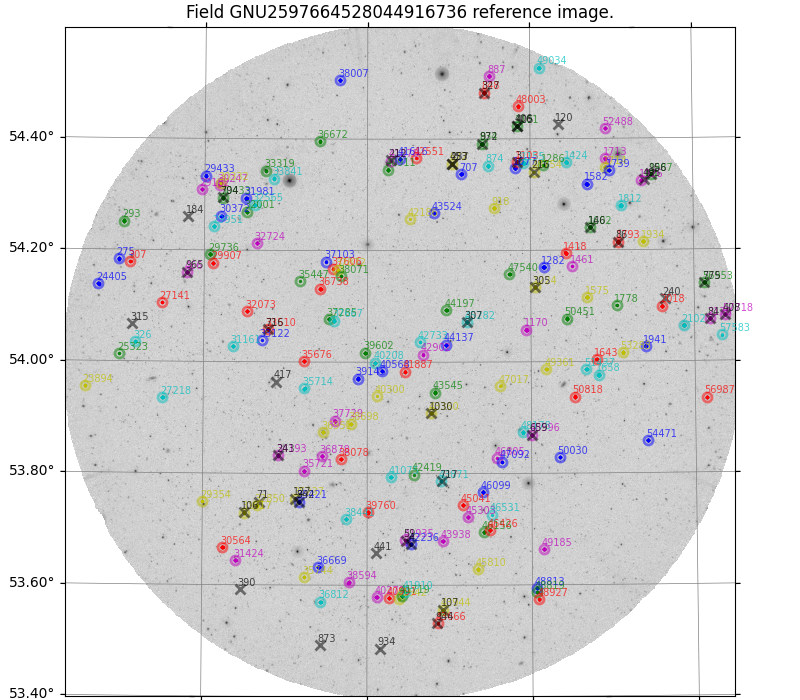

In [4]:
#PS_ELAISN1_MOS15 is field_id GNU2597664528044916736 (TDE PS1-10jh field)
field_id = rg.tt_fields["field_id"][5]
fd = rg.fields[field_id]
fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

plot_tds = {"marker":"x","color":"k"}
ax = vvis.plot_sky_sources(tt_tds, src_id="recno",src_kwargs=plot_tds, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

In [ ]:
import vasca.visualization as vvis
fig_fd_det_diag_scat = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
fig_rg_src_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
#fig_det_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist",fig_size=(8, 10))